In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Make sure we can import from src/
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), ""))

from src.features import prepare_features
from src.model import load_model
from src.pricing import generate_candidates, inventory_bias, choose_price

In [2]:
df = pd.read_csv("../data/synthetic_data.csv", parse_dates=["timestamp"])
df.head()


,timestamp,product_id,price,competitor_price,visitors,stock,promotion,day_of_week,hour,season,sales
0,2024-01-01 00:00:00,101,300.0,397.23,207,76,0,0,0,festive,17
1,2024-01-01 01:00:00,101,350.0,405.58,228,80,1,0,1,festive,35
2,2024-01-01 02:00:00,101,400.0,390.69,203,72,0,0,2,festive,15
3,2024-01-01 03:00:00,101,400.0,404.44,185,62,0,0,3,festive,15
4,2024-01-01 04:00:00,101,450.0,389.69,219,63,0,0,4,festive,12


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         4320 non-null   datetime64[ns]
 1   product_id        4320 non-null   int64         
 2   price             4320 non-null   float64       
 3   competitor_price  4320 non-null   float64       
 4   visitors          4320 non-null   int64         
 5   stock             4320 non-null   int64         
 6   promotion         4320 non-null   int64         
 7   day_of_week       4320 non-null   int64         
 8   hour              4320 non-null   int64         
 9   season            4320 non-null   object        
 10  sales             4320 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)
memory usage: 371.4+ KB


In [4]:
df.describe(include='all')


,timestamp,product_id,price,competitor_price,visitors,stock,promotion,day_of_week,hour,season,sales
count,4320,4320.0,4320.000000,4320.00000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320,4320.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3600,NaN
mean,2024-03-30 23:29:59.999999744,101.0,367.210648,399.81862,200.154630,49.600926,0.043750,2.972222,11.500000,NaN,13.690046
min,2024-01-01 00:00:00,101.0,200.000000,287.44000,111.000000,2.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,2024-02-14 23:45:00,101.0,300.000000,368.00000,180.000000,36.000000,0.000000,1.000000,5.750000,NaN,9.000000
50%,2024-03-30 23:30:00,101.0,400.000000,399.31500,200.000000,50.000000,0.000000,3.000000,11.500000,NaN,12.000000
75%,2024-05-14 23:15:00,101.0,450.000000,431.95250,221.000000,63.000000,0.000000,5.000000,17.250000,NaN,17.000000
max,2024-06-28 23:00:00,101.0,500.000000,507.36000,292.000000,101.000000,1.000000,6.000000,23.000000,NaN,61.000000


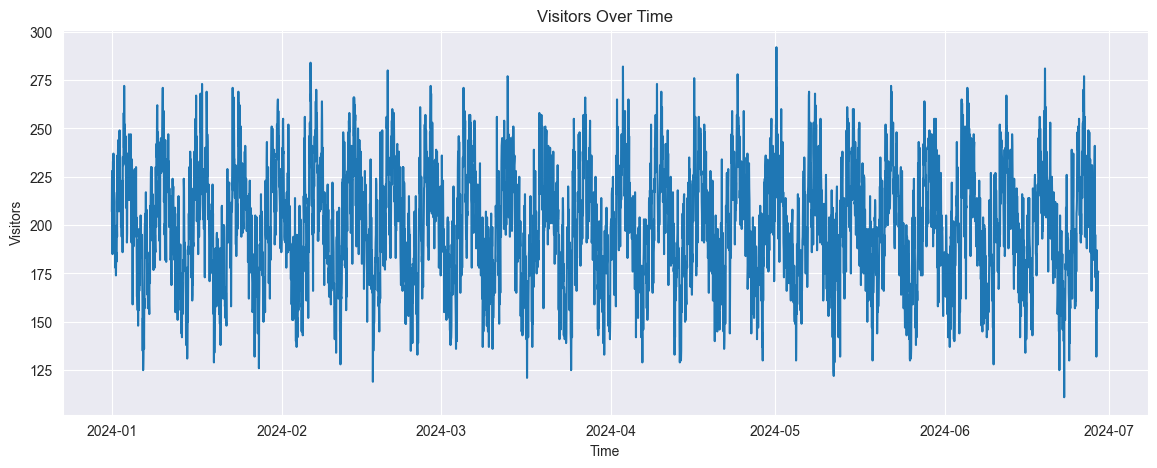

In [5]:
plt.figure(figsize=(14,5))
plt.plot(df['timestamp'], df['visitors'])
plt.title("Visitors Over Time")
plt.xlabel("Time")
plt.ylabel("Visitors")
plt.grid(True)
plt.show()


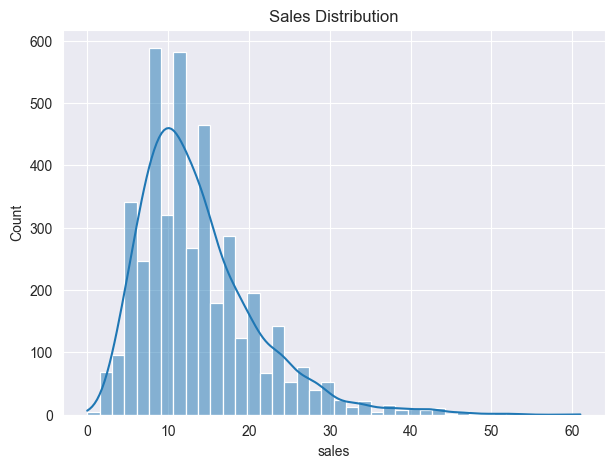

In [6]:
plt.figure(figsize=(7,5))
sns.histplot(df['sales'], bins=40, kde=True)
plt.title("Sales Distribution")
plt.show()


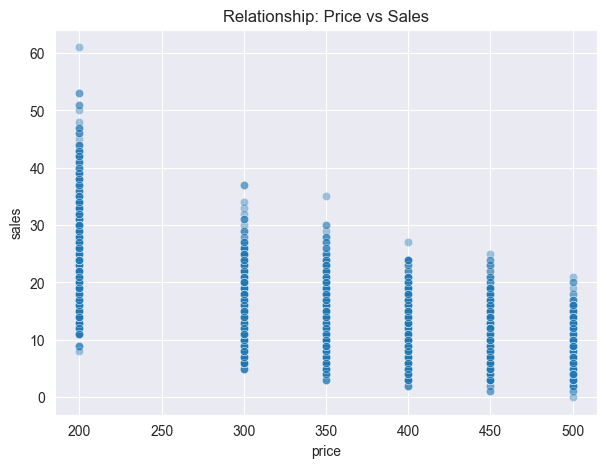

In [7]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='price', y='sales', alpha=0.4)
plt.title("Relationship: Price vs Sales")
plt.show()


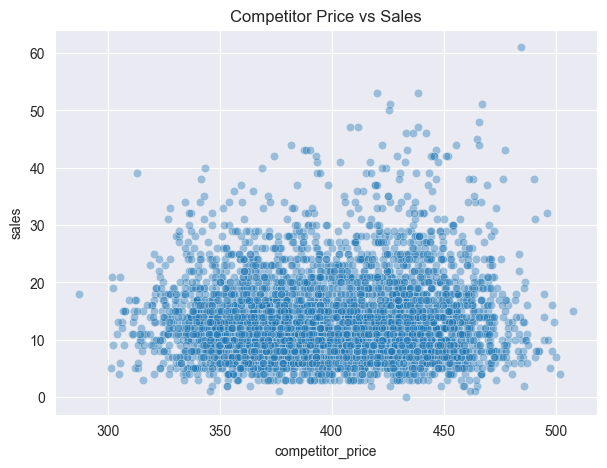

In [8]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='competitor_price', y='sales', alpha=0.4)
plt.title("Competitor Price vs Sales")
plt.show()


In [9]:
MODEL_PATH = "../models/xgb_model.json"
model = load_model(MODEL_PATH)

# load feature order
feature_cols = list(np.load("../models/feature_cols.npy", allow_pickle=True))
feature_cols


[np.str_('price'),
 np.str_('competitor_price'),
 np.str_('price_ratio'),
 np.str_('log_price'),
 np.str_('log_visitors'),
 np.str_('visitors'),
 np.str_('stock'),
 np.str_('promotion'),
 np.str_('day_of_week'),
 np.str_('hour'),
 np.str_('season_festive'),
 np.str_('stock_bucket_medium'),
 np.str_('stock_bucket_high')]

In [10]:
sample = df.sample(1).iloc[0]
sample


timestamp           2024-05-14 14:00:00
product_id                          101
price                             350.0
competitor_price                 374.46
visitors                            219
stock                                38
promotion                             0
day_of_week                           1
hour                                 14
season                           normal
sales                                18
Name: 3230, dtype: object

In [11]:
context = {
    'competitor_price': sample['competitor_price'],
    'visitors': sample['visitors'],
    'stock': sample['stock'],
    'promotion': sample['promotion'],
    'day_of_week': sample['day_of_week'],
    'hour': sample['hour'],
    'season_festive': 1 if sample['season']=='festive' else 0,
}
context


{'competitor_price': np.float64(374.46),
 'visitors': np.int64(219),
 'stock': np.int64(38),
 'promotion': np.int64(0),
 'day_of_week': np.int64(1),
 'hour': np.int64(14),
 'season_festive': 0}

In [12]:
candidates = generate_candidates(base_price=sample['price'])
results = []

for p in candidates:
    row = dict(context)
    row['price'] = p
    row['price_ratio'] = p / context['competitor_price']
    row['log_price'] = np.log(p)
    row['log_visitors'] = np.log1p(context['visitors'])

    Xdf = pd.DataFrame([row])

    # add missing columns
    for col in feature_cols:
        if col not in Xdf.columns:
            Xdf[col] = 0

    Xdf = Xdf[feature_cols].astype(float)

    pred_sales = model.predict(Xdf)[0]
    revenue = p * pred_sales
    bias = inventory_bias(context['stock'])
    score = revenue * bias

    results.append({
        'price': p,
        'pred_sales': pred_sales,
        'revenue': revenue,
        'score': score
    })

res_df = pd.DataFrame(results)
res_df.head()


,price,pred_sales,revenue,score
0,245.0,21.626919,5298.595104,5298.595104
1,270.0,21.451605,5791.933308,5791.933308
2,295.0,20.778738,6129.727716,6129.727716
3,320.0,14.436163,4619.572144,4619.572144
4,345.0,14.369270,4957.398262,4957.398262


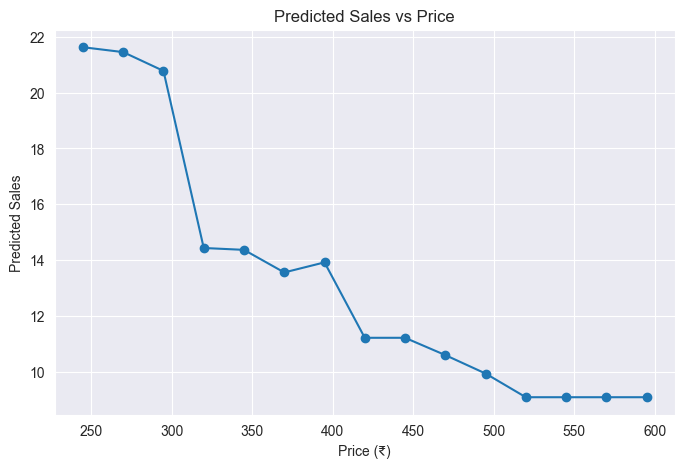

In [13]:
plt.figure(figsize=(8,5))
plt.plot(res_df['price'], res_df['pred_sales'], marker='o')
plt.title("Predicted Sales vs Price")
plt.xlabel("Price (₹)")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.show()


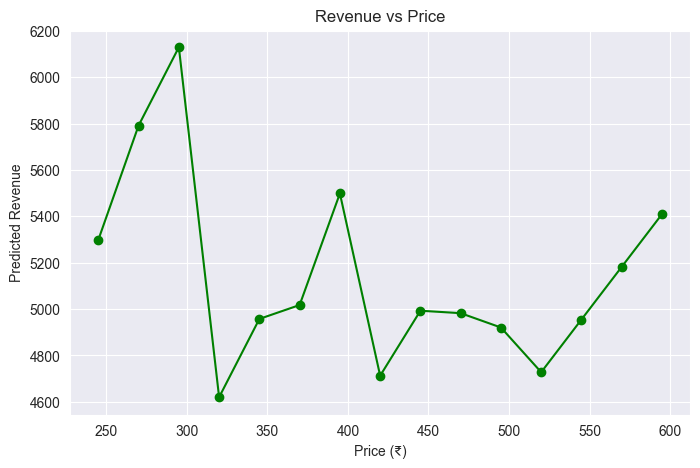

In [14]:
plt.figure(figsize=(8,5))
plt.plot(res_df['price'], res_df['revenue'], marker='o', color='green')
plt.title("Revenue vs Price")
plt.xlabel("Price (₹)")
plt.ylabel("Predicted Revenue")
plt.grid(True)
plt.show()


In [15]:
best_price = res_df.loc[res_df['score'].idxmax(), 'price']
best_price


np.float64(295.0)

In [16]:
stocks = [5, 15, 30, 60]
heat = []

for s in stocks:
    row_vals = []
    for p in candidates:
        row = dict(context)
        row['stock'] = s
        row['price'] = p
        row['price_ratio'] = p / context['competitor_price']
        row['log_price'] = np.log(p)
        row['log_visitors'] = np.log1p(context['visitors'])

        Xdf = pd.DataFrame([row])
        for col in feature_cols:
            if col not in Xdf.columns:
                Xdf[col] = 0

        Xdf = Xdf[feature_cols].astype(float)
        pred_sales = model.predict(Xdf)[0]
        revenue = p * pred_sales

        score = revenue * inventory_bias(s)
        row_vals.append(score)

    heat.append(row_vals)

heat_df = pd.DataFrame(heat, index=stocks, columns=candidates)
heat_df


,245.0,270.0,295.0,320.0,345.0,370.0,395.0,420.0,445.0,470.0,495.0,520.0,545.0,570.0,595.0
5,5885.959646,6389.480995,6767.716715,4978.631149,5329.203132,5393.695760,5911.204829,5080.320132,5382.720140,5372.192377,5289.394338,5074.035349,5317.979356,5561.923363,5805.867370
15,5427.344780,5943.703251,6295.550432,4631.284790,4957.398262,5017.391405,5498.795190,4725.879192,5007.181525,4997.388258,4920.366826,4720.032883,4946.957541,5173.882198,5400.806856
30,5427.344780,5951.752453,6304.344931,4640.824890,4957.398262,5017.391405,5498.795190,4725.879192,5007.181525,4997.388258,4920.366826,4727.513199,4954.797487,5182.081776,5409.366064
60,5123.445955,5582.426356,5938.212208,4388.593536,4689.758189,4764.708649,5221.919732,4474.651500,4740.999803,4730.807287,4611.137294,4454.049002,4668.185973,4882.322944,5096.459915


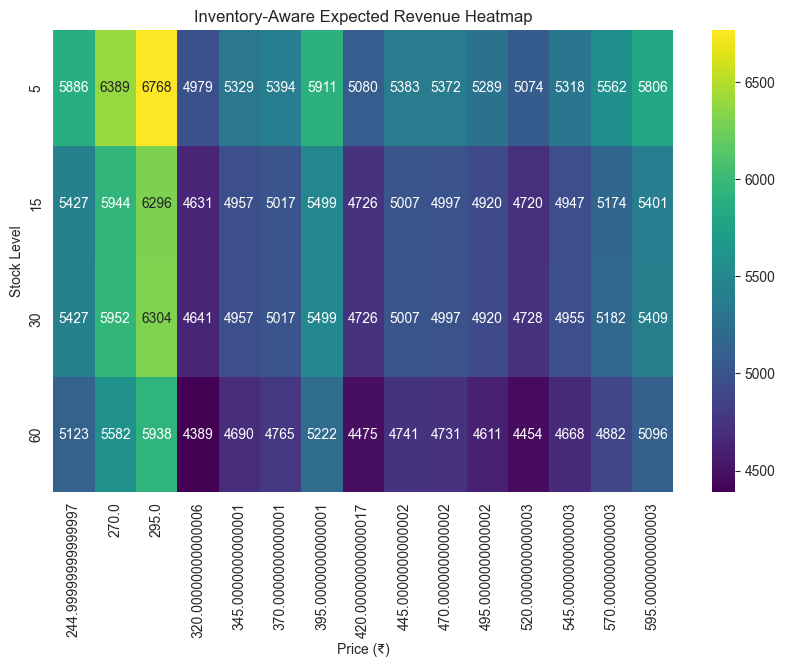

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(heat_df, annot=True, fmt=".0f", cmap="viridis")
plt.title("Inventory-Aware Expected Revenue Heatmap")
plt.xlabel("Price (₹)")
plt.ylabel("Stock Level")
plt.show()
